In [51]:
import edward as ed
import numpy as np
import seaborn as sns
import tensorflow as tf

from edward.models import Normal
from matplotlib import pyplot as plt

%matplotlib inline

In [29]:
def build_toy_dataset(N, w, noise_std=0.1):
    D = len(w)
    x = np.random.randn(N, D)
    y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
    return x, y

In [30]:
np.random.seed(0)

N = 40
D = 1

# Decide on the 'true' value of w, then build toy test & train
# datasets
w_true = np.random.randn(D)
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [40]:
# Define the model
X = tf.placeholder(tf.float32, (N, D))
w = Normal(tf.zeros(D), tf.ones(D))
b = Normal(tf.zeros(1), tf.ones(1))
y = Normal(ed.dot(X, w) + b, tf.ones(N))

# Now this bit is required for variational inference
# These are the "posterior variables", which represent the variational
# approximation to the latent variables b & w when at the posterior.
qw = Normal(tf.Variable(tf.random_normal((D,))),
            tf.nn.softplus(tf.Variable(tf.random_normal((D,)))))
qb = Normal(tf.Variable(tf.random_normal((1,))),
            tf.nn.softplus(tf.Variable(tf.random_normal((1,)))))

latent_to_posterior = {b: qb, w: qw}

y_post = ed.copy(y, latent_to_posterior)

In [57]:
inference = ed.KLqp(latent_to_posterior, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 41.436


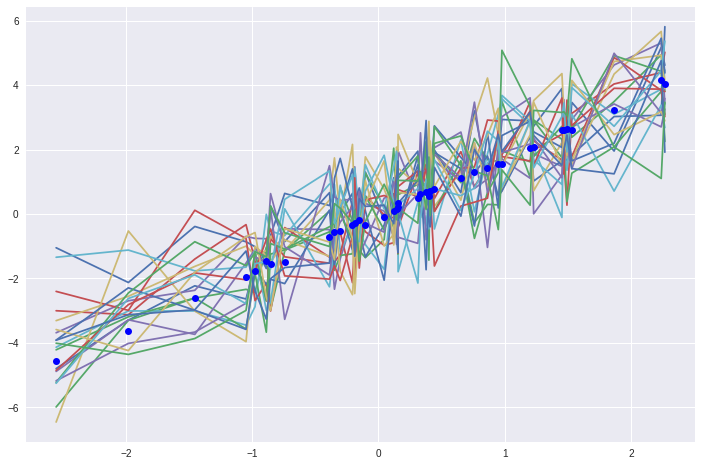

In [42]:
sample_ys = [y_post.eval(feed_dict={X: X_train}) for _ in range(20)]
i_sorted = np.argsort(X_train[:,0])

plt.figure(figsize=(12, 8))
for sample_y in sample_ys:
    plt.plot(X_train[i_sorted], sample_y[i_sorted])
plt.plot(X_train, y_train, 'bo');

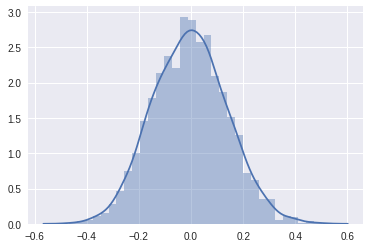

In [55]:
sns.distplot([qb.eval() for _ in range(2000)]);